In [12]:
import polars as pl
import numpy as np
import pandas as pd
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt
import os
import warnings
import seaborn as sns

diretorio = "D:\dados - tcc mba/csv_files"
warnings.filterwarnings("ignore")


# Tratamento dos dados
- set_table_dtypes = Dados de colunas que terminam em 'P' ou 'A' são transformados em float64;
- convert_strings = Converte colunas de strings em um DataFrame pandas em colunas categóricas
- filter_cols = deleta colunas com mais de 30% dos dados nulos;
- filter_nans = retira colunas que dependendo do limite da quantidade de 'nan';


In [2]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df


def filter_cols(df):
    # Retira colunas que tenham mais de 80% de valores nulos
    colunas_fixas = ["target", "case_id", "WEEK_NUM", 'totalamount_6A',
                    'totalamount_996A', 'totaldebtoverduevalue_178A', 'totaldebtoverduevalue_718A',
                    'totaloutstanddebtvalue_39A', 'totaloutstanddebtvalue_668A']
    cols_to_drop = []
    for col in df.columns:
        if col not in colunas_fixas:
            isnull = df[col].isnull().mean()
            if isnull > 0.7:
                cols_to_drop.append(col)

    df = df.drop(columns=cols_to_drop, errors='ignore')

    # Vê a quantidade de valores únicos na coluna, se a coluna tiver exatamente um valor único ou mais de 200, essa coluna é excluída
    cols_to_drop = []
    for col in df.columns:
        if col not in colunas_fixas:
            unique_count = df[col].nunique()
            if unique_count == 1 or unique_count > 200:
                cols_to_drop.append(col)

    df = df.drop(columns=cols_to_drop, errors='ignore')

    return df



def filter_nans(df, limite):
    # Calcular a proporção de valores NaN em cada coluna
    proporcao_nans = df.isna().mean()

    # Selecionar colunas que têm proporção de NaN menor ou igual ao limite
    colunas_para_manter = proporcao_nans[proporcao_nans <= limite].index

    # Filtrar o DataFrame para manter apenas as colunas selecionadas
    df_filtrado = df[colunas_para_manter]

    return df_filtrado


def filter_unique(df):
    # Contagem de valores únicos em cada coluna
    unique_counts = df.nunique()

    # Selecionar colunas que têm número de valores únicos entre 2 e 200 (inclusive)
    colunas_para_manter = unique_counts[(unique_counts > 1) & (unique_counts <= 100)].index

    # Filtrar o DataFrame para manter apenas as colunas selecionadas
    df_filtrado = df[list(colunas_para_manter)]

    return df_filtrado 



def filter_data(df, limite_nans=0.15):
    """
    Filtra o DataFrame para manter apenas as colunas que atendem aos critérios específicos:
    - Para colunas numéricas (float64 e int64): remove colunas com proporção de NaN menor ou igual ao limite.
    - Para colunas categóricas (object e category): mantém colunas com número de valores únicos entre 1 e 100.

    Parâmetros:
    df (DataFrame): DataFrame pandas de entrada.
    limite_nans (float): Limite percentual de NaNs permitido para colunas numéricas (por padrão, 0.15 para 15%).

    Retorno:
    DataFrame: DataFrame com colunas filtradas.
    """
    colunas_para_manter = []

    for coluna in df.columns:
        if df[coluna].dtype in ['float64', 'int64']:
            # Verifica a proporção de NaNs na coluna
            proporcao_nans = df[coluna].isna().mean()
            if proporcao_nans > limite_nans:
                colunas_para_manter.append(coluna)
        elif df[coluna].dtype in ['object', 'category']:
            # Verifica o número de valores únicos na coluna
            num_valores_unicos = df[coluna].nunique()
            if 1 <= num_valores_unicos <= 10:
                colunas_para_manter.append(coluna)

    # Filtra o DataFrame para manter apenas as colunas selecionadas
    df_filtrado = df[colunas_para_manter]

    return df_filtrado
    


# Importação de dados do diretório
Precisa-se de um método e explicações para selecionar determinadas bases, visto que tenho recurso computacional limitado.

In [3]:
# ---------- Dados Treino

train_basetable = pl.read_csv(diretorio + "/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(diretorio + "/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(diretorio + "/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(diretorio + "/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(diretorio + "/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(diretorio + "/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes)

In [4]:
# ---------- Dados Teste

test_basetable = pl.read_csv(diretorio + "/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(diretorio + "/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(diretorio + "/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(diretorio + "/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(diretorio + "/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(diretorio + "/test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv(diretorio + "/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

# Agrupamento e organização dos dados
O depth vai de 0 a 2, sendo que zero é o conjunto de dados menos agrupados (mais granulares) e dois são os dados mais agrupados (menos granulares)


In [5]:
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed"))


# Pessoa que solicitou o empréstimo
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Agrupamento
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)


selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)


selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)


# Join
data_treino = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

data_treino.head()

case_id,date_decision,MONTH,WEEK_NUM,target,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,disbursedcredamount_1113A,downpmt_116A,inittransactionamount_650A,lastapprcommoditycat_1041M,lastapprcommoditytypec_5251766M,lastapprcredamount_781A,lastcancelreason_561M,lastotherinc_902A,lastotherlnsexpense_631A,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectreason_759M,lastrejectreasonclient_4145040M,maininc_215A,maxannuity_159A,maxannuity_4075009A,maxdebt4_972A,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,previouscontdistrict_112M,price_1097A,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A,mainoccupationinc_384A_max,mainoccupationinc_384A_any_selfemployed,person_housetype,pmts_pmtsoverdue_635A_max,pmts_dpdvalue_108P_over31
i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,str,f64,f64,str,str,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,bool,str,f64,bool
0,"""2019-01-03""",201901,0,0,null,1917.6,0.0,null,null,null,null,30000.0,0.0,0.0,30000.0,0.0,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,10800.0,false,null,null,null
1,"""2019-01-03""",201901,0,0,null,3134.0,0.0,null,null,null,null,19999.8,0.0,0.0,19999.8,0.0,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,10000.0,false,null,null,null
2,"""2019-01-04""",201901,0,0,null,4937.0,0.0,null,null,null,null,78000.0,0.0,0.0,78000.0,0.0,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",10000.0,"""a55475b1""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,14000.0,false,null,null,null
3,"""2019-01-03""",201901,0,0,null,4643.6,0.0,null,null,null,null,40000.0,0.0,0.0,40000.0,0.0,null,"""a55475b1""","""a55475b1""",null,"""P94_109_143""",null,null,"""a55475b1""","""a55475b1""",59999.8,"""P94_109_143""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,10000.0,false,null,null,null
4,"""2019-01-04""",201901,0,1,null,3390.2,0.0,null,null,null,null,44000.0,0.0,0.0,44000.0,0.0,null,"""a55475b1""","""a55475b1""",null,"""P24_27_36""",null,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,24000.0,false,null,null,null


# Variáveis utilizadas
Apresentar glossário de variáveis no trabalho, mas apenas as que estão sendo usadas.


In [ ]:
# glossario = pd.read_excel('D:/dados - tcc mba/feature_definitions.xlsx')
# glossario

# variaveis = pd.DataFrame({'Variable':data_treino.columns})

# var_definitions = variaveis.merge(glossario, how='left')
# var_definitions
# # var_definitions[var_definitions['Description'].isna()]

In [6]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_teste = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

data_teste.head()

case_id,date_decision,MONTH,WEEK_NUM,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,disbursedcredamount_1113A,downpmt_116A,inittransactionamount_650A,lastapprcommoditycat_1041M,lastapprcommoditytypec_5251766M,lastapprcredamount_781A,lastcancelreason_561M,lastotherinc_902A,lastotherlnsexpense_631A,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectreason_759M,lastrejectreasonclient_4145040M,maininc_215A,maxannuity_159A,maxannuity_4075009A,maxdebt4_972A,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,previouscontdistrict_112M,price_1097A,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A,mainoccupationinc_384A_max,mainoccupationinc_384A_any_selfemployed,person_housetype,pmts_pmtsoverdue_635A_max,pmts_dpdvalue_108P_over31
i64,str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,str,f64,f64,str,str,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,bool,str,f64,bool
57543,"""2021-05-14""",202201,100,191767.36,3674.6,1218.2001,16049.4,17054.4,14554.4,24482.0,20000.0,12154.4,0.0,20000.0,0.0,null,"""a55475b1""","""a55475b1""",14000.0,"""a55475b1""",null,null,"""P109_133_183""","""P49_111_165""",24000.0,"""a55475b1""","""a55475b1""",34000.0,280983.56,null,231440.03,131700.8,16672.6,157731.78,16641.4,"""a55475b1""",0.0,12154.4,12154.4,12154.4,456031.1,17859.6,"""2fc785b2""","""6b2ae0fa""","""a55475b1""","""38c061ee""","""a55475b1""",null,null,null,null,34000.0,false,null,null,null
57549,"""2022-01-17""",202201,100,129704.4,5742.6,3546.6,32426.201,118964.805,13681.714,32426.201,75000.0,10638.2,10638.2,75000.0,0.0,null,"""a55475b1""","""a55475b1""",94000.0,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",160000.0,"""a55475b1""","""P30_86_84""",44000.0,337659.8,null,34066.0,122511.4,31820.6,21278.0,122511.4,"""a55475b1""",null,10638.2,10638.2,10638.2,373720.84,126058.0,"""2fc785b2""","""39a0853f""","""a55475b1""","""a7fcb6e5""","""a55475b1""",null,null,26815.6,null,49800.0,false,null,null,null
57551,"""2020-11-27""",202201,100,71036.4,2844.6,0.0,8357.2,null,0.0,9551.0,27095.201,0.0,0.0,27095.201,0.0,null,"""a55475b1""","""a55475b1""",200000.0,"""P85_114_140""",null,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""","""a55475b1""",70000.0,83400.0,null,54000.0,41783.402,54000.0,62619.0,null,"""P11_36_178""",27095.201,0.0,0.0,0.0,75219.0,null,"""2fc785b2""","""6b2ae0fa""","""a55475b1""","""3439d993""","""a55475b1""",null,null,null,null,59600.0,false,null,null,null
57552,"""2020-11-27""",202201,100,183992.0,6298.8003,12155.4,7440.4,null,199322.4,9148.4,100000.0,191269.61,191269.61,100000.0,0.0,null,"""a55475b1""","""a55475b1""",0.0,"""P94_109_143""",null,null,"""a55475b1""","""a55475b1""",150000.0,"""a55475b1""","""P94_109_143""",null,110500.0,null,188126.14,12155.4,104473.6,288642.6,12155.4,"""P21_87_50""",null,191269.61,191269.61,191269.61,284213.0,18889.0,"""2fc785b2""","""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,23402.8,null,112000.0,false,"""OWNED""",null,null
57569,"""2021-12-20""",202201,100,0.0,4682.6,0.0,null,null,null,10796.4,60000.0,0.0,0.0,60000.0,0.0,null,"""a55475b1""","""a55475b1""",20000.0,"""P94_109_143""",null,null,"""a55475b1""","""a55475b1""",40000.0,"""a55475b1""","""P94_109_143""",6000.0,37704.0,null,64555.668,null,null,0.0,null,"""a55475b1""",null,0.0,0.0,0.0,95348.42,null,"""2fc785b2""","""717ddd49""","""a55475b1""","""3439d993""","""a55475b1""",null,null,17333.6,null,58000.0,false,"""OWNED""",null,null


# Tratamento dos IDs, seleção de colunas, conversão polars para pandas

In [7]:
# Embaralha os IDs de casos únicos no conjunto de dados data_treino e divide esses IDs em treino, teste e validação
case_ids = data_treino["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

# Adiciona à lista cols_pred todas as colunas cujo último caractere é uma letra maiúscula e os caracteres anteriores são letras minúsculas.
cols_pred = []
for col in data_treino.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

# Polars para Pandas
def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data_treino.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data_treino.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data_treino.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, treino_x, treino_y = from_polars_to_pandas(case_ids_train)
base_valid, valid_x, valid_y = from_polars_to_pandas(case_ids_valid)
base_test, teste_x, teste_y = from_polars_to_pandas(case_ids_test)


for df in [treino_x, valid_x, teste_x]:
    df = convert_strings(df)

In [8]:
print(f"Treino: {treino_x.shape}")
print(f"Validação: {valid_x.shape}")
print(f"Teste: {teste_x.shape}")

Treino: (915995, 48)
Validação: (305332, 48)
Teste: (305332, 48)


In [ ]:
# descritivas_treino = treino_x.describe()
# descritivas_treino.to_excel('descritivas_treino.xlsx')

# Retira colunas que tenham mais de 50% de valores nulos

In [9]:
limite = 0.15

treino_x = filter_data(treino_x, limite)
valid_x = filter_data(valid_x, limite)
teste_x = filter_data(teste_x, limite)

print(f"Treino: {treino_x.shape}")
print(f"Validação: {valid_x.shape}")
print(f"Teste: {teste_x.shape}")



Treino: (915995, 30)
Validação: (305332, 30)
Teste: (305332, 30)


# Análise descritiva das features quantitativas da base treino


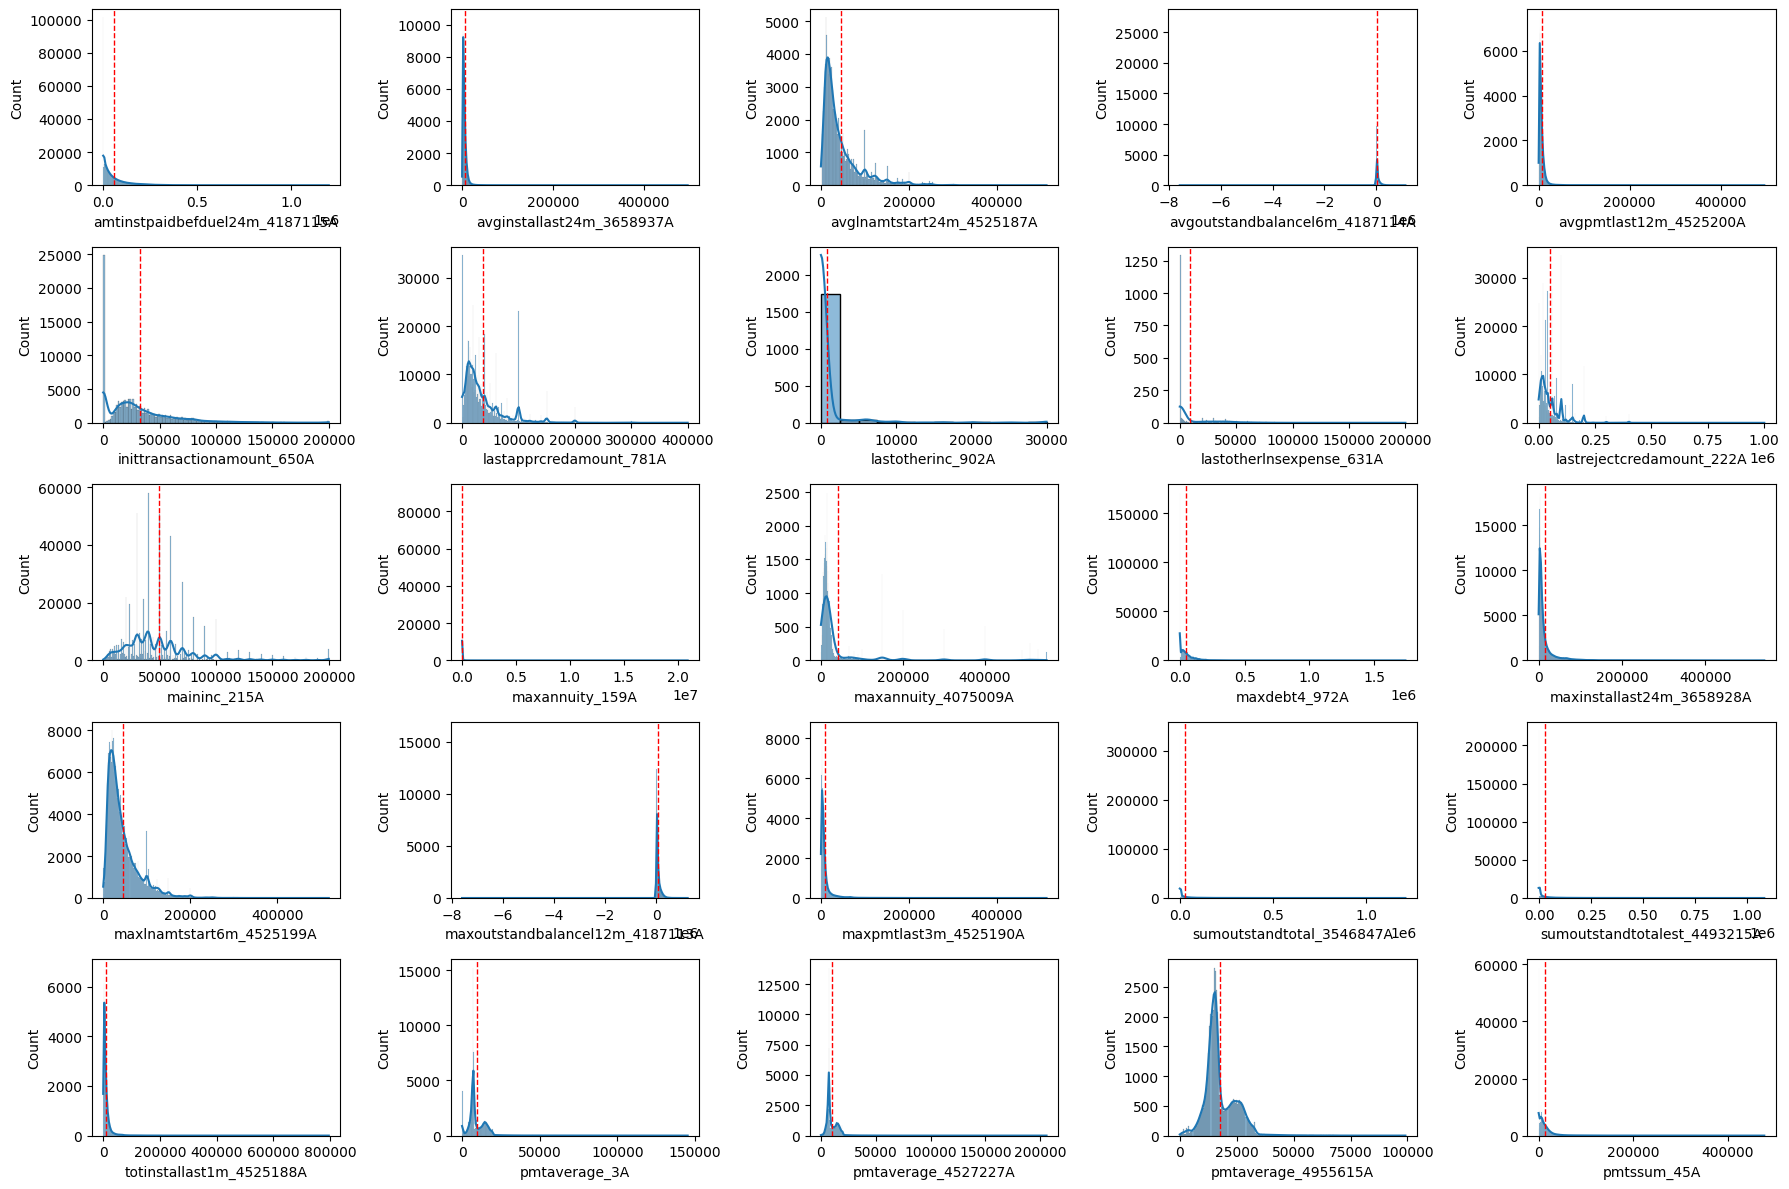

In [14]:
var_quant = treino_x.select_dtypes(exclude=['object', 'category'])


# Calcular a média das variáveis quantitativas
mean_var_quant = var_quant.mean().round(2)

# Configuração para melhor visualização dos gráficos
plt.figure(figsize=(18, 12))  # Ajuste o tamanho da figura conforme necessário

# Plotar histogramas para cada variável quantitativa baseado na média
for i, col in enumerate(var_quant.columns):
    plt.subplot(5, 5, i + 1)  # Organize os gráficos em uma grade de 5x5
    sns.histplot(var_quant[col], kde=True)
    plt.axvline(mean_var_quant[col], color='red', linestyle='dashed', linewidth=1)  # linha para média

plt.tight_layout()
plt.show()

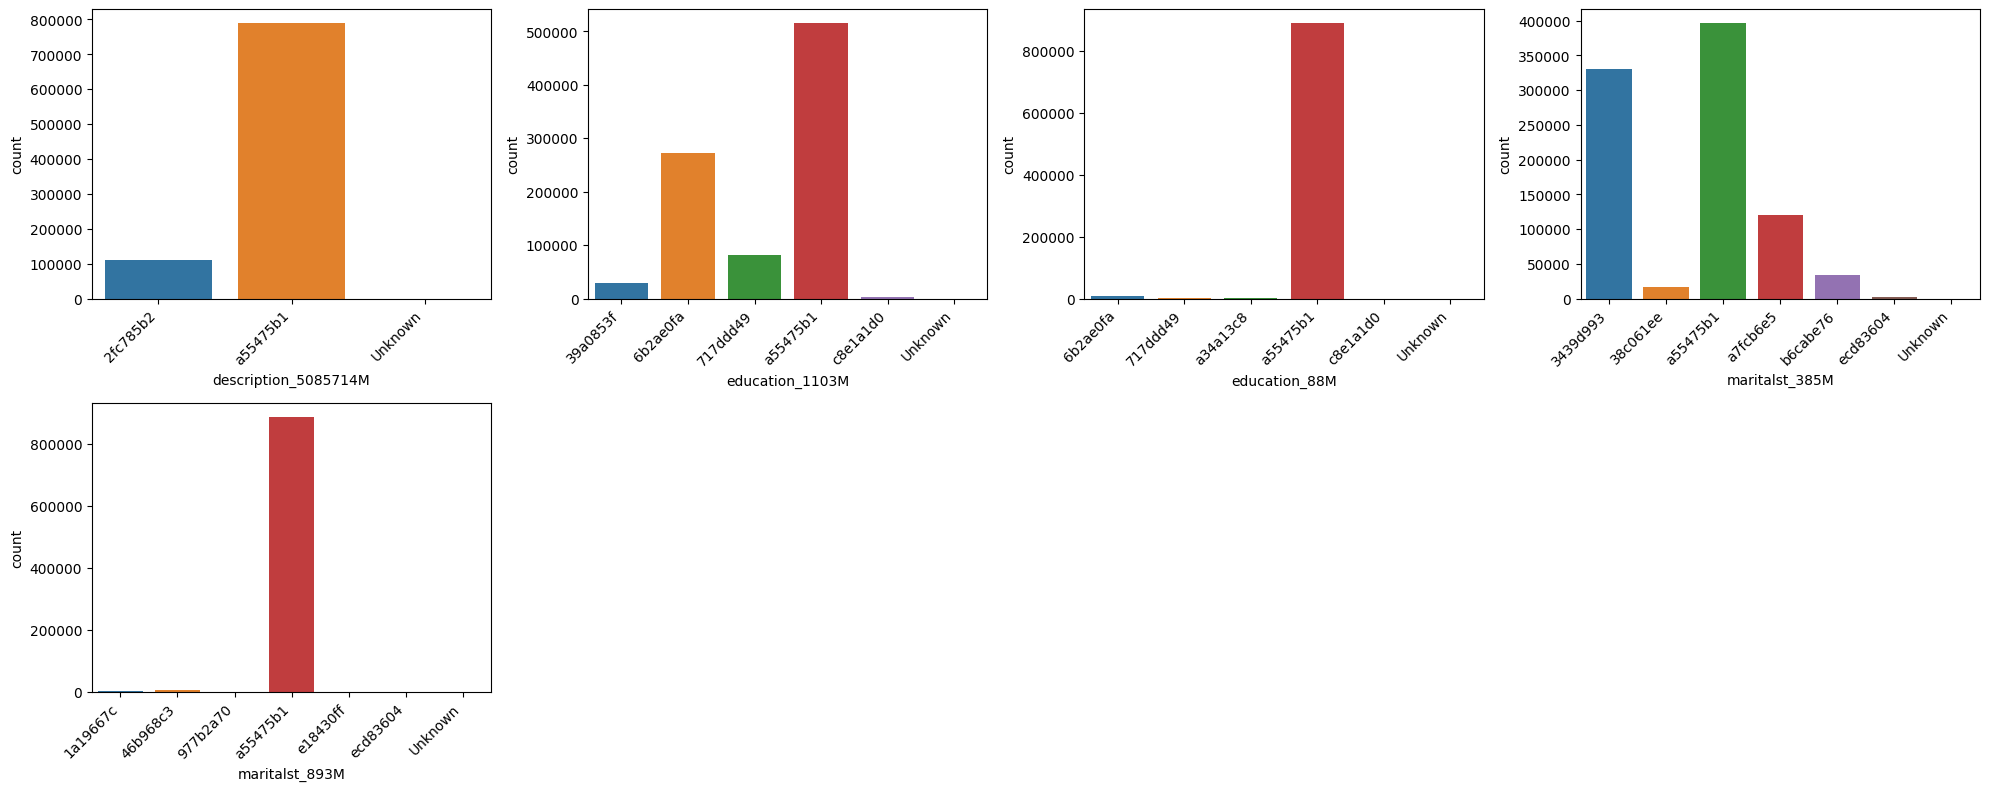

In [21]:
var_quali = treino_x.select_dtypes(include=['object', 'category'])

# Criar DataFrame
var_quali = pd.DataFrame(var_quali)

# Configuração para visualização dos gráficos
plt.figure(figsize=(20, 15))  # Ajuste o tamanho da figura conforme necessário

# Plotar gráficos de contagem para cada variável qualitativa
for i, col in enumerate(var_quali.columns):
    plt.subplot(4, 4, i + 1)  # Organize os gráficos em uma grade de 4x4
    sns.countplot(x=col, data=var_quali)
    plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos do eixo x para melhorar a legibilidade

plt.tight_layout()
plt.show()


# Preenchendo valores NaN com a média

In [15]:
# 1. Selecionar colunas numéricas
colunas_numericas_treino = treino_x.select_dtypes(include=['float64', 'int64']).columns
colunas_numericas_valid = valid_x.select_dtypes(include=['float64', 'int64']).columns
colunas_numericas_teste = teste_x.select_dtypes(include=['float64', 'int64']).columns

# 2. Imputação de valores ausentes usando SimpleImputer
imputador = SimpleImputer(strategy='mean')

# Para a base de treino
treino_x[colunas_numericas_treino] = imputador.fit_transform(treino_x[colunas_numericas_treino])

# Para a base de validação
valid_x[colunas_numericas_valid] = imputador.transform(valid_x[colunas_numericas_valid])

# Para a base de teste
teste_x[colunas_numericas_teste] = imputador.transform(teste_x[colunas_numericas_teste])

C:\Users\Computadores Gamer\AppData\Local\Temp\ipykernel_22024\1422664710.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste_x[colunas_numericas_teste] = imputador.transform(teste_x[colunas_numericas_teste])


# Análise fatorial para diminuir dimensionalidade das variáveis


In [ ]:
var_numericas = treino_x.select_dtypes(include=['float64', 'int64']).columns
var_categoricas = treino_x.select_dtypes(exclude=['number']).columns

# Pipeline para pré-processamento de variáveis
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Normalização ou padronização dos dados numéricos, se necessário
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, var_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), var_categoricas)
    ])

# Aplicar pré-processamento e ajustar a matriz de treino
treino_x_preprocessed = preprocessor.fit_transform(treino_x)
treino_x_preprocessed_df = pd.DataFrame(treino_x_preprocessed, index=treino_x.index, columns=var_numericas.tolist() + preprocessor.named_transformers_['cat'].get_feature_names_out(var_categoricas).tolist())

# Aplicar o mesmo pré-processamento nos conjuntos de validação e teste
valid_x_preprocessed = preprocessor.transform(valid_x)
teste_x_preprocessed = preprocessor.transform(teste_x)

# Combinar fatores (se aplicável) com as colunas originais
# Análise Fatorial
n_factors = 5
fa = FactorAnalysis(n_components=n_factors, random_state=42)

# Ajustar e transformar os dados de treino
treino_x_factors = fa.fit_transform(treino_x_preprocessed_df)

# Transformar os dados de validação e teste
valid_x_factors = fa.transform(valid_x_preprocessed)
teste_x_factors = fa.transform(teste_x_preprocessed)

# Converter de volta para DataFrames
treino_x_factors_df = pd.DataFrame(treino_x_factors, index=treino_x.index, columns=[f'Factor{i+1}' for i in range(n_factors)])
valid_x_factors_df = pd.DataFrame(valid_x_factors, index=valid_x.index, columns=[f'Factor{i+1}' for i in range(n_factors)])
teste_x_factors_df = pd.DataFrame(teste_x_factors, index=teste_x.index, columns=[f'Factor{i+1}' for i in range(n_factors)])

# Combinar fatores com as colunas numéricas originais
treino_x_combined = treino_x.drop(columns=var_categoricas).join(treino_x_factors_df)
valid_x_combined = valid_x.drop(columns=var_categoricas).join(valid_x_factors_df)
teste_x_combined = teste_x.drop(columns=var_categoricas).join(teste_x_factors_df)




<Figure size 1000x600 with 0 Axes>

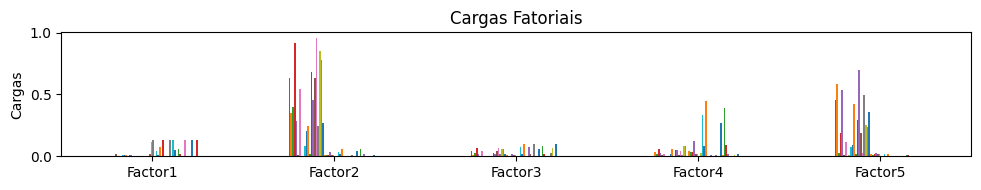

In [32]:
# Calcular as cargas fatoriais
cargas_fatoriais = fa.components_
cargas_fatoriais_df = pd.DataFrame(cargas_fatoriais, columns=treino_x_preprocessed_df.columns, index=[f'Factor{i+1}' for i in range(n_factors)])

# Exibir as cargas fatoriais
# print("\nCargas Fatoriais:")
# print(cargas_fatoriais_df)

# Plotar as cargas fatoriais
plt.figure(figsize=(10, 6))
cargas_fatoriais_df.abs().plot(kind='bar', figsize=(10, 2), legend=False)
plt.title('Cargas Fatoriais')
plt.ylabel('Cargas')
plt.xticks(rotation=0)
# plt.legend(loc='upper right')
plt.tight_layout()
plt.show()



# Top 10 Variáveis:

In [36]:
# Identificar as 10 variáveis com maior carga fatorial por fator
top_variables_per_factor = {}
for factor in cargas_fatoriais_df.index:
    sorted_vars = cargas_fatoriais_df.loc[factor].abs().sort_values(ascending=False)
    top_variables = sorted_vars.index[:10]  # Seleciona as top 10 variáveis com maior carga fatorial
    top_variables_per_factor[factor] = top_variables.tolist()

# Criar DataFrame formatado
df_top_variables = pd.DataFrame.from_dict(top_variables_per_factor, orient='index').transpose()

# Adicionar uma linha de descrição
df_top_variables = pd.concat([pd.DataFrame([['Top Variáveis com Maior Carga Fatorial'] * n_factors], columns=df_top_variables.columns), df_top_variables], ignore_index=True)

# Exibir a tabela formatada
print(df_top_variables)

                                   Factor1  \
0   Top Variáveis com Maior Carga Fatorial   
1                 description_5085714M_nan   
2                      education_1103M_nan   
3                       maritalst_385M_nan   
4                        education_88M_nan   
5                       maritalst_893M_nan   
6                   education_88M_a55475b1   
7                  maritalst_893M_a55475b1   
8            description_5085714M_a55475b1   
9                 education_1103M_a55475b1   
10                 maritalst_385M_a55475b1   

                                   Factor2  \
0   Top Variáveis com Maior Carga Fatorial   
1          maxoutstandbalancel12m_4187113A   
2           avgoutstandbalancel6m_4187114A   
3                sumoutstandtotal_3546847A   
4             sumoutstandtotalest_4493215A   
5                            maxdebt4_972A   
6                 maxlnamtstart6m_4525199A   
7           amtinstpaidbefduel24m_4187115A   
8                  lastapprcredam

In [ ]:
# Definir o modelo RandomForestClassifier
rf = RandomForestClassifier(random_state=123)

# Treinar o modelo usando os dados de treino combinados
rf.fit(treino_x_combined, treino_y)



# Avaliação do modelo

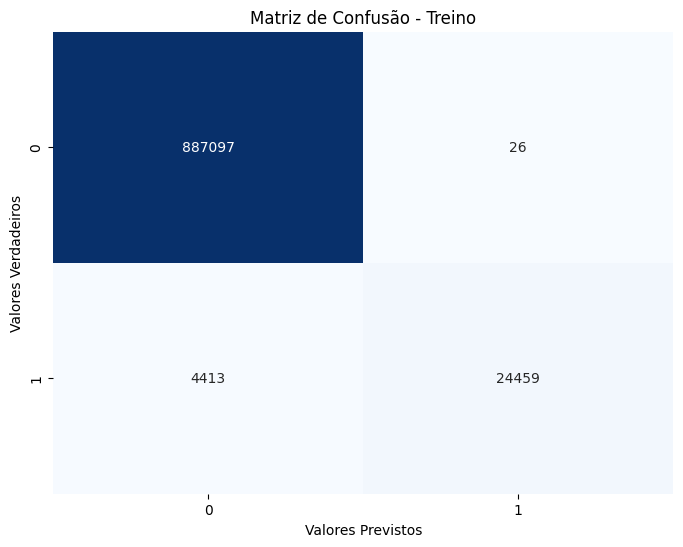

Treino:
F1-score: 0.9168
ROC-AUC score: 0.9864
Acurácia: 0.9952
----------------------------------------


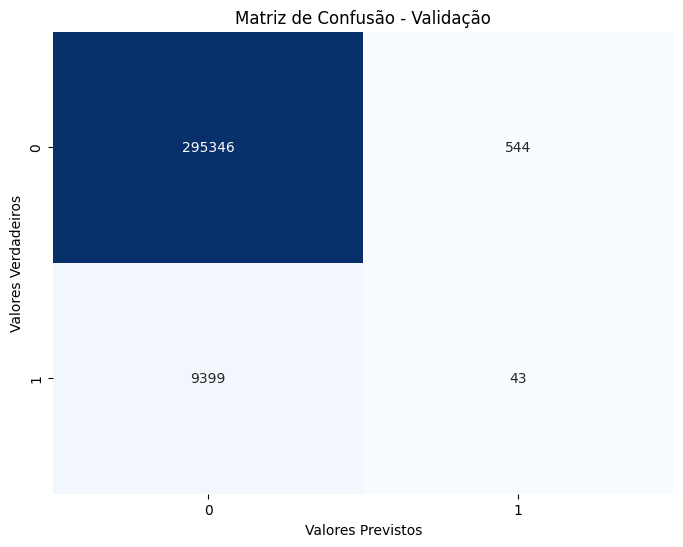

Validação:
F1-score: 0.0086
ROC-AUC score: 0.6422
Acurácia: 0.9674
----------------------------------------


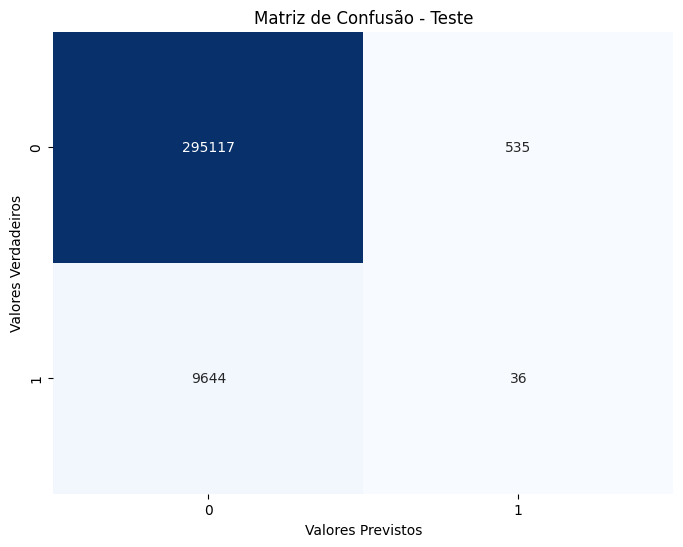

Teste:
F1-score: 0.0070
ROC-AUC score: 0.6504
Acurácia: 0.9667
----------------------------------------

Modelo RandomForestClassifier:
RandomForestClassifier(random_state=123)


In [38]:
# Avaliar o modelo nos conjuntos de treino, validação e teste
for i, x, y in zip(['Treino', 'Validação', 'Teste'],
                    [treino_x_combined, valid_x_combined, teste_x_combined],
                    [treino_y, valid_y, teste_y]):
    # Prever os valores
    y_pred = rf.predict(x)

    # Calcular a matriz de confusão
    matriz_confusao = confusion_matrix(y, y_pred)

    # Calcular o F1-score
    f1 = f1_score(y, y_pred)

    # Calcular o ROC-AUC score
    y_proba = rf.predict_proba(x)[:, 1]
    roc_auc = roc_auc_score(y, y_proba)

    # Calcular a acurácia
    acuracia = accuracy_score(y, y_pred)

    # Plotar a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusão - {i}')
    plt.xlabel('Valores Previstos')
    plt.ylabel('Valores Verdadeiros')
    plt.show()

    # Exibir o F1-score, ROC-AUC score e acurácia
    print(f'{i}:')
    print(f'F1-score: {f1:.4f}')
    print(f'ROC-AUC score: {roc_auc:.4f}')
    print(f'Acurácia: {acuracia:.4f}')
    print('-' * 40)


# 1 inadimplentes
# 0 adimplentes